# COMP3314 Programming Assignment 1

## Due: October 31, 2023 at 23:00 p.m.

Welcome to our first programming assignment! Here are five programming tasks in total and all the parts you need to code are wrapped by comments like

```python
def some_func():
    ...
    # Requirements:
    # 1. Your code should ...
    ######## your code starts here ########


    ######## your code ends here   ########
    ....
```

Have fun with this notebook!

We recommend you to use either [Colab](https://colab.research.google.com/) or your own local Python environment for this programming assignment. 

- To set up the Colab environment, you need to open https://colab.research.google.com/ and click `File -> Open notebook -> upload the provided notebook file`. There are many online [tutorials](https://colab.research.google.com/notebooks/basic_features_overview.ipynb) for Colab, which you could refer to for relevant information.
- It is also OK to use your own native environment. Note that your Python version should be higher than 3.6 with [NumPy](https://numpy.org/install/), [PyTorch](https://pytorch.org/), and [Matplotlib](https://matplotlib.org/) packages installed.

You do not need to write a report; just write codes and add text blocks in the notebook appropriately. Submit your notebook in `.ipynb` format (**with all outputs saved**) to Moodle. To export your notebook in Colab, simply click `File -> Download -> Download .ipynb` on your Colab tab.

# Task: Classification via Gaussian Naive Bayes and Multilayer Perceptron

In this assignment, you will utilize NumPy to construct a basic Gaussian Naive Bayes Classifier (NBC) and PyTorch to build a Multi-Layer Perceptron (MLP) for solving a toy classification problem.

### Basic environment setup

In [91]:
# Basic setup
import numpy as np
import torch
from torch import nn
import os
from sklearn.datasets import load_iris
# this line is only used for presenting the results in a more readable way
np.set_printoptions(precision=3)

# set the seed for the random number generator
# this is only used for reproducibility of the results
np.random.seed(seed=3314)
torch.manual_seed(3314)
# matplotlib is used to plot/visualize things
import matplotlib.pyplot as plt # import matplotlib.pyplot for plotting figures
plt.style.use('ggplot') # use "ggplot" style for graphs
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(3314)
    torch.cuda.manual_seed_all(3314)
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Loading the well-known Iris dataset

The Iris dataset, introduced by Ronald Fisher in 1936, is a renowned dataset in machine learning and statistics. It comprises measurements of four features (Sepal length, Sepal width, Petal length, and Petal width) from three species of Iris flowers. The objective is to classify the flowers into their respective species using these features. With 150 samples and distinct classes, the Iris dataset is widely used for classification algorithm practice and exploring machine learning techniques.

In [78]:
# loading the iris dataset
iris = load_iris()
# print the basic information about the dataset
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

#### Visualizing the Iris dataset

X shape: (150, 4)
y shape: (150,)


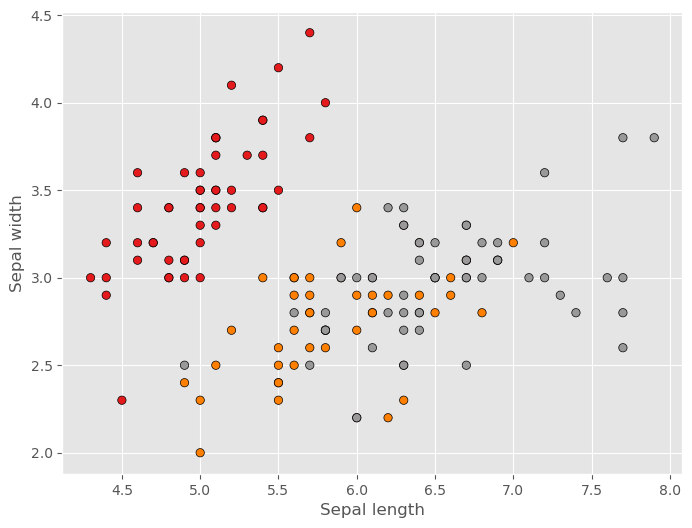

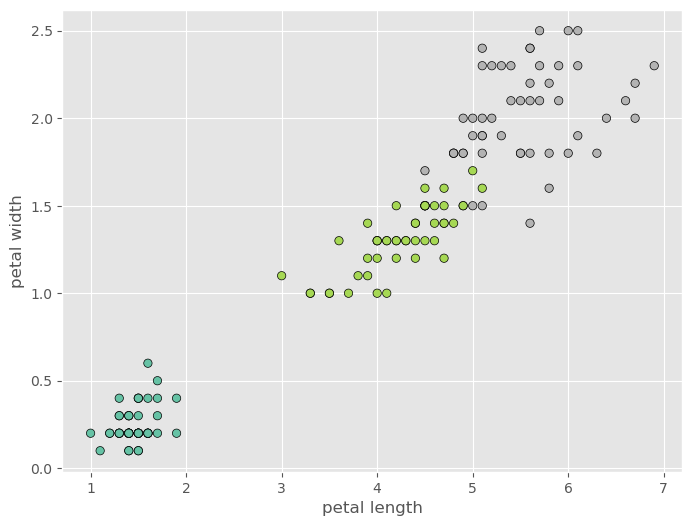

In [79]:
# read the features and the labels
X = iris.data
y = iris.target

# print the shape of the features and the labels
print("X shape:", X.shape)
print("y shape:", y.shape)

# visualize the features
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 2], X[:, 3], c=y, cmap=plt.cm.Set2, edgecolor='k')
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.show()

#### Splitting the Iris dataset

In [90]:
test_data_index = np.linspace(0, 149, 30, dtype=int)
train_data_index = np.setdiff1d(np.arange(150), test_data_index)
x_test, y_test = X[test_data_index], y[test_data_index]
x_train, y_train = X[train_data_index], y[train_data_index]

num_classes = 3 # the number of classes
D = 4 # the number of features, namely the dimension of the data

# plt.figure(figsize=(8, 6))
# plt.plot(y_train, 'o', c='b', label='train')
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.plot(y_test, 'o', c='r', label='test')
# plt.show()

While the dataset may not be large, it serves as an excellent starting point for practicing classification algorithms. In the first section, we will train a Gaussian Naive Bayes Classifier (NBC) using the Iris dataset. Subsequently, we will implement a Multi-Layer Perceptron (MLP) for the same classification task.

---

## Section 1: Gaussian Naive Bayes Classifier


### 1. Gaussian distribution

#### 1.1 Univairate Gaussian distribution
Recall the probability density function (pdf) of a univariate Gaussian (or normal) distribution is defined as
$$
p(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left ({-\frac{1}{2\sigma^2}(x - \mu)^2} \right).
$$
Sometimes it is denoted by $\mathcal{N}(x;\mu,\sigma^2)$. A univariate Gaussian distribution has two parameters:
- $\mu$, which encodes the mean value and controls the localtion;
- $\sigma$, whose square $\sigma^2$ encodes the variance and controls the scale. 

#### 1.2 Multivariate Gaussian distribution

The pdf of the multivariate Gaussian for a $D$-dimensional variable $X$ is
$$
p(x; \mu, \Sigma) = \frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}}\exp \left ({-\frac{1}{2}(x - \mu)^\top \Sigma^{-1} (x - \mu)} \right).
$$
It has two sets of parameters:
- $\mathbf{\mu} \in \mathbb{R}^D$, encoding the mean for each dimensionality;
- $\Sigma \in \mathbb{R}^{D \times D}$ is the covariance matrix which is analogous to the variance $\sigma^2$; however, it not only the scale of each dimensionality, but also encodes the relationship between two dimensions. Each element $\Sigma_{i,j}$ is the covariance for dimensions $i$ and $j$ : $\Sigma_{i,j} = \operatorname{Cov}(X_i,X_j) = \mathbb{E}[(X_i-\mathbb{E}[X_i])(X_j-\mathbb{E}[X_j])]$.

#### 1.3 Multivariate Gaussian distribution with diagonal covariance matrix

Here, we consider a special case where the covariance matrix $\Sigma$ is diagonal, i.e., $\Sigma = \operatorname{diag}(\sigma_1^2, \sigma_2^2, \ldots, \sigma_D^2)$. In this case, the pdf of the multivariate Gaussian is
$$
\begin{aligned}
p(x; \mu, \Sigma) &= \frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}}\exp \left ({-\frac{1}{2}(x - \mu)^\top \Sigma^{-1} (x - \mu)} \right) \\
&= \frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}}\exp \left ({-\frac{1}{2}\sum_{i=1}^D \frac{(x_i - \mu_i)^2}{\sigma_i^2}} \right) \\
&= \frac{1}{(2\pi)^{D/2}\prod_{i=1}^D \sigma_i}\exp \left ({-\frac{1}{2}\sum_{i=1}^D \frac{(x_i - \mu_i)^2}{\sigma_i^2}} \right) \\
&= \prod_{i=1}^D \frac{1}{\sqrt{2\pi \sigma_i^2}} \exp \left ({-\frac{1}{2\sigma_i^2}(x_i - \mu_i)^2} \right).
\end{aligned}
$$

Therefore, **the pdf of the multivariate Gaussian with diagonal covariance matrix is simply a **product** of $D$ univariate Gaussian distributions**.

#### **Task 1: calculate the pdf of the Gaussian distributions (20 points)**

In this task, you need to use NumPy to implement a function that calculates the pdf of the Gaussians (support both the univariate Gaussian (10 pts) and the multivariate Gaussian distribution with diagonal covariance matrix (10 pts)), given some data point $x$ and the corresponding parameters $(\mu, \sigma)$.

Typically, we assume the input x is a numpy array of $N$ data points with $D$ dimention, and the output is a numpy array of $N$ density values evaluated at corresponding points. The parameters $\mu$ and $\sigma$ are numpy arrays with shape ($D$).

Example:

For the univariate Gaussian, input x is a numpy array of $N$ data points with shape ($N$), and the output is a numpy array of $N$ density values with shape ($N$). The parameters $\mu$ and $\sigma$ are scalars. 

For the multivariate Gaussian **with diagonal covariance matrix**, input x is a numpy array of $N$ $D$-dimentional data points with shape ($N$, $D$), and the output is a numpy array of $N$ density values with shape ($N$). The parameters $\mu$ and $\sigma$ are numpy arrays with shape ($D$), where each element of $\sigma$ is the standard deviation of the corresponding dimensionality.


In [81]:
# the function to compute the pdf of p(x; \mu, \sigma)
def gaussian_pdf(x, mu, sigma):
    """
    Returns the Gaussian density function evaluated at x,
    with parameters mu and sigma.

    x: 
        Univariate case: x.shape == [N], where N is the number of data points.
        Miltivariate case: x.shape == [N, D], where N is the number of data points and D is the dimensionality of the data.
    mu: 
        Univariate case: mu is a scalar.
        Miltivariate case: mu.shape == [D], where D is the dimensionality of the data.
    sigma: 
        Univariate case: sigma is a scalar.
        Miltivariate case: sigma.shape == [D], where D is the dimensionality of the data. 
        (Here we assume that the covariance matrix is diagonal, i.e. Sigma[i, j] = 0 if i != j.
        We only take the diagonal elements of the covariance matrix to form the parameter sigma.)

    return
    y: y.shape == [N], where N is the number of data points.
       y is the pdf of p(x; \mu, \sigma) evaluated at each point in x.
    """
    # #### Your code starts here #####
    # you need to consider the input shape to decide the case of Gaussian distribution
    # ... 
    # y = None
    # return y
    # #### Your code ends here #####


If your implementation is correct, running the following code blocks should produce a figure similar to this, which visualizes 3 different Gaussian distributions with different parameters.

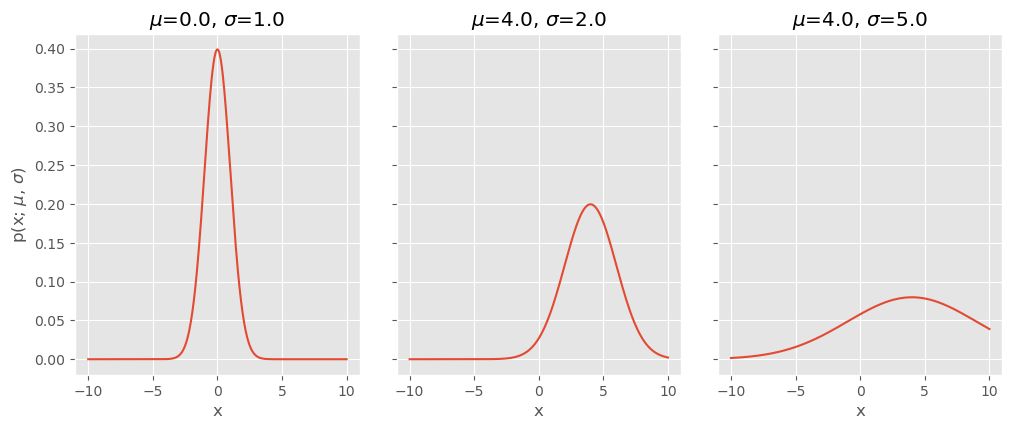

In [82]:
def plot_univariate_gaussian():
    _mus_and_simgas = [(0, 1), (4, 2), (4, 5)]

    # plotting utilities
    # create a figure with 1 rows and 3 columns with proper spacing
    fig, ax = plt.subplots(1,len(_mus_and_simgas), figsize=(10,4), sharey=True) #placeholders for 2 row x 2 columns images
    fig.tight_layout() # automatically adjusts spacing of subplots.
    x = np.linspace(-10, 10, 500) # generate 500 evenly placed values of x from -10 to 10
    for i in range(len(_mus_and_simgas)):
        mu, sigma = _mus_and_simgas[i]
        # Gaussian distribution with parameter (mu, sigma)
        ax[i].plot(x, gaussian_pdf(x, mu, sigma))
        ax[i].set_title(f'$\\mu$={mu:.1f}, $\\sigma$={sigma:.1f}')
        if i == 0:
            ax[i].set_ylabel('p(x; $\mu$, $\sigma$)')
        ax[i].set_xlabel('x')
    plt.show()

plot_univariate_gaussian()

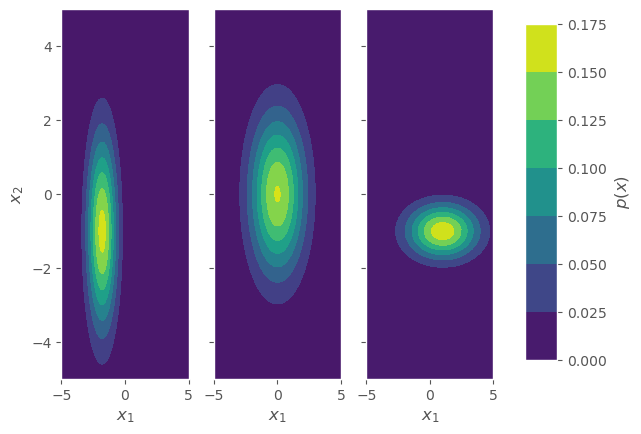

In [83]:
def plot_multivariate_gaussian():
    mu_0 = [-1.8, -1.0]
    mu_1 = [0.0, 0.0]
    mu_2 = [1.0, -1.0]
    Sigma_0 = [0.8, 1.8]
    Sigma_1 = [1.5, 1.5]
    Sigma_2 = [1.9, 0.5]
    # store the parameters in a list
    mus = np.array([mu_0, mu_1, mu_2])
    Sigmas = np.array([Sigma_0, Sigma_1, Sigma_2])

    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
    # build 2D grid
    x1, x2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100)) 
    x = np.stack([x1, x2], axis=-1).reshape(10000, 2)
    for i, ax in enumerate(axes):
        z = gaussian_pdf(x, mus[i], Sigmas[i])
        img = ax.contourf(x1, x2, z.reshape(100, 100))
        ax.set_xlabel("$x_1$")
        if i == 0:
            ax.set_ylabel("$x_2$")
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(img, cax=cbar_ax)
    cbar.set_label("$p(x)$")
    plt.show()

plot_multivariate_gaussian()

### 2. Gaussian Naive Bayes Classifiers (NBCs)

#### 2.1 An overview

Naive Bayes classifiers are a kind of generative classifiers, which not only models the **class posterior distribution** $p(y|\boldsymbol{x};\boldsymbol{\theta})$ for prediction, but also models the **class conditional probability** $p(\boldsymbol{x}|y;\boldsymbol{\theta})$.

To clarify the **prior** and **posterior** distributions:
- the class **prior** distribution is denoted by $p(y;\boldsymbol{\pi})$; it encodes our prior belief about the class probalitiy $\pi$ without the knowledge of $\boldsymbol{x}$;
- the class **posterior** distribution is $p(y|\boldsymbol{x};\boldsymbol{\theta})$; it reflects our updated belief about the class probability after observing $\boldsymbol{x}$.

##### Formulation

The main idea of NBC models is to impose **conditional independence** on the class conditional probability density $p(\boldsymbol{x}|y;\boldsymbol{\theta})$. In other words, the feature dimensions are independent of each other conditional on the class variable $y$. Supposing $y=c$, we have 
$$
 p(\boldsymbol{x}|y=c;\boldsymbol{\theta}) = \prod_{d=1}^D p(x_{d}|y=c;\boldsymbol{\theta}_{dc}).
$$

##### Maximum Likelihood Estimation (MLE)

All data points in the dataset $D = \{(\boldsymbol{x}_n, y_n)\}_{n=1}^N$ are assumed i.i.d. (**independent** and identically distributed). If we denote $\boldsymbol{x}_{nd}$ as the $d$-th dimension of the $n$-th data point, this further means
$$
\begin{aligned}
p(D;\boldsymbol{\theta}) &= \prod_{n=1}^N p(\boldsymbol{x}_n, y_n|\boldsymbol{\theta})\\
&= \prod_{n=1}^N p(y_n;\boldsymbol{\pi}) p(\boldsymbol{x}_n|y_n;\boldsymbol{\theta})\\
&= \prod_{n=1}^N p(y_n;\boldsymbol{\pi}) \prod_{d=1}^{D} p\left(x_{nd} | y_n, \boldsymbol{\theta}_{d y_n}\right).
\end{aligned}
$$

We fit the model via maximum likelihood estimation for the joint distribution over $x$ and $y$. The negative log likelihood (NLL) function is
$$
\begin{aligned}
-\log p(D;\boldsymbol{\theta}) &= -\log\prod_{n=1}^N p(y_n;\boldsymbol{\pi}) \prod_{d=1}^{D} p\left(x_{nd} | y_n, \boldsymbol{\theta}_{d y_n}\right) \\
&= -\left(\sum_{n=1}^N \log p(y_n;\boldsymbol{\pi}) + \sum_{n=1}^N \log p\left(x_{nd} | y_n, \boldsymbol{\theta}_{d y_n}\right)\right).
\end{aligned}
$$
Our goal is to estimate $\boldsymbol{\pi}$ and $\boldsymbol{\theta}$. Since the log likelihood functions involving $\boldsymbol{\pi}$ and $\boldsymbol{\theta}$ are decoupled, we could estimate them individually via maximum likelihood estimation. In addition, they would typically have closed-form solutions, as we see below.

In this case, we have real-valued features ($x_d \in \mathbb{R}$ for each $d$). A suitable way is to model each feature dimension through a univariate Gaussian distribution $p(x_d|y=c;\boldsymbol{\theta}_{dc}) = \mathcal{N}(x_d|\mu_{dc}, \sigma^2_{dc})$.

Thus in our NBC model, there are three sets of parameters:
- $\boldsymbol{\pi}$: a $C$-dimensional vector, each dimension of which corresponds to the prior class probability. According to the lecture and textbook, this actually defines a categorical distribution and its parameter can be estimated as (denote $N_c$ as the number of data points for class $c$ and $N$ is the total number of data points)
$$
\widehat{\pi}_{c}=\frac{N_{c}}{N}.
$$
- $\boldsymbol{\mu}$: the mean of each class conditional density. It consists of $C$ vectors for each class and each vector is $D$-dimensional; for Gaussian distributions, it is known that the MLE for mean is
$$
\widehat{\mu}_{d c} =\frac{1}{N_{c}} \sum_{n: y_{n}=c} x_{n d}.
$$
- $\boldsymbol{\sigma}$: the standard deviation of each class conditional density. It consists of $C$ vectors for each class and each vector is $D$-dimensional. The MLE for the variance is
$$
\widehat{\sigma}_{d c}^{2} =\frac{1}{N_{c}} \sum_{n: y_{n}=c}\left(x_{n d}-\widehat{\mu}_{d c}\right)^{2}.
$$

#### **Task 2: Implement Maximum Likelihood Estimation (MLE) (20 points)**

In this task, you need to implement the maximum likelihood estimation (MLE) above for the parameters of the naive Bayes classifier, including
- the parameter $\pi$ of the class prior probability (10 pts);
- the parameters $(\mu, \sigma)$ of the Gaussian distribution (10 points in total, 5 points for each);

In [84]:
# estimate parameter pi for prior class probability
def estimate_pi(y, num_classes):
    """
    Returns the prior class probability, pi, estimated from the data labels.

    y: y.shape == [N], where N is the number of data points.
    num_classes: the number of classes.

    return
    estimated_pi: estimated_pi.shape == [num_classes]
    """
    N = y.shape[0] # the total number of data points
    estimated_pi = np.zeros(num_classes)
    # #### Your code starts here #####
    # estimated_pi = None
    # #### Your code ends here #####
    return estimated_pi

# estimate parameter theta = (mu, sigma) for class conditional probability
def estimate_theta(x, y, num_classes):
    """
    Returns the class conditional probability parameters, theta, estimated from the data.

    x: x.shape == [N, D], where N is the number of data points and D is the dimensionality of the data.
    y: y.shape == [N], where N is the number of data points.
    num_classes: the number of classes.

    return
    estimated_mu: estimated_mu.shape == [num_classes, D]
    estimated_Sigma: estimated_Sigma.shape == [num_classes, D, D]
    """
    N, D = x.shape # N is the number of data points and D is the dimensionality of the data
    estimated_mu = np.zeros((num_classes, D))
    estimated_Sigma = np.zeros((num_classes, D, D))
    # #### Your code starts here #####
    # estimated_mu = None
    # estimated_Sigma = None
    # #### Your code ends here #####
    return estimated_mu, estimated_Sigma


You can test the NBC model by running the following code blocks. If your implementation is correct, you should be able to see the following output:

```

In [85]:
_estimated_pi = estimate_pi(y_train, num_classes)
_estimated_mu, _estimated_Sigma = estimate_theta(x_train, y_train, num_classes)

print("Estimated pi: {}".format(_estimated_pi))
for class_c in range(num_classes):
	print("=====> Class {}".format(class_c))
	estimated_mu_class_c = _estimated_mu[class_c].tolist()
	print("Estimated mu: {}".format(estimated_mu_class_c))

	estimated_Sigma_class_c = _estimated_Sigma[class_c].tolist()
	print("Estimated Sigma: {}".format(estimated_Sigma_class_c))

Estimated pi: [0.333 0.333 0.333]
=====> Class 0
Estimated mu: [4.9725, 3.4274999999999998, 1.4499999999999995, 0.24500000000000002]
Estimated Sigma: [[0.11949375000000002, 0.0, 0.0, 0.0], [0.0, 0.10099374999999997, 0.0, 0.0], [0.0, 0.0, 0.029999999999999992, 0.0], [0.0, 0.0, 0.0, 0.011975000000000001]]
=====> Class 1
Estimated mu: [5.892499999999998, 2.7425, 4.237499999999999, 1.305]
Estimated Sigma: [[0.29169374999999986, 0.0, 0.0, 0.0], [0.0, 0.09744375000000002, 0.0, 0.0], [0.0, 0.0, 0.24134375000000005, 0.0], [0.0, 0.0, 0.0, 0.038974999999999996]]
=====> Class 2
Estimated mu: [6.597499999999999, 3.0049999999999994, 5.552499999999999, 2.045]
Estimated Sigma: [[0.3987437500000003, 0.0, 0.0, 0.0], [0.0, 0.11247499999999999, 0.0, 0.0], [0.0, 0.0, 0.26499375, 0.0], [0.0, 0.0, 0.0, 0.07597499999999999]]


#### 2.2 Prediction
After fitting an NBC model, we would like to predict the label of unseen data points $(\boldsymbol{x}, y)$.

In particular, we would like to compute the posterior class probability based on Bayes' theorem
$$
\begin{aligned}
p(y=c | \boldsymbol{x}; \boldsymbol{\theta}) &= \frac{p(\boldsymbol{x}, y=c;\boldsymbol{\theta})}{p(\boldsymbol{x};\boldsymbol{\theta})} \\
&= \frac{p(y=c;\boldsymbol{\pi})p(\boldsymbol{x}|y=c;\boldsymbol{\theta})}{\sum_{c'} p(y=c';\boldsymbol{\pi})p(\boldsymbol{x}|y=c;\boldsymbol{\theta})} \\
&= \frac{p(y=c ; \boldsymbol{\pi}) \prod_{d=1}^{D} p\left(x_{d} | y=c; \boldsymbol{\theta}_{d c}\right)}{\sum_{c^{\prime}} p\left(y=c^{\prime} ; \boldsymbol{\pi}\right) \prod_{d=1}^{D} p\left(x_{d} | y=c^{\prime}; \boldsymbol{\theta}_{d c^{\prime}}\right)}.
\end{aligned}
$$
By simply comparing the posterior probability of each class, we could **predict the label by assigning it to the class with the largest probability.**

#### **Task 3: Implement Naive Bayes Classifier prediction (20 points)**


The Naive Bayes Classifier (NBC) implementation follows a similar style as our `LogisticRegression` model in our previous tutorial:
- Training is handled by the `fit()` method, which takes in the training data and labels and estimates the model parameters via your MLE implementation.
- **Your task is to implement its `predict()` method, which predicts the label of given test data points.**

In [86]:
class NaiveBayesClassifier(object):
    '''
    Naive Bayes Classifier

    '''
    def __init__(self, num_classes, D):
        self.num_classes = num_classes
        self.D = D
        # initialize the parameters
        self.pi = np.zeros(num_classes)
        self.mu = np.zeros((num_classes, D))
        self.sigma = np.zeros((num_classes, D))

    def fit(self, x, y):
        """
        Fit the model parameters from the data features and labels.

        x: x.shape == [N, D], where N is the number of data points and D is the dimensionality of the data.
        y: y.shape == [N], where N is the number of data points.

        computes
        self.pi: self.pi.shape == [num_classes]
        self.mu: self.mu.shape == [num_classes, D]
        self.sigma: self.sigma.shape == [num_classes, D]
        """
        self.pi = estimate_pi(y, self.num_classes)
        self.mu, self.sigma = estimate_theta(x, y, self.num_classes)

    def predict(self, x):
        """    
        Predict the class labels for the input data features.

        x: x.shape == [M, D], where M is the number of test data points and D is the dimensionality of the data.

        returns
        y_pred: y_pred.shape == [M], the predicted labels for each data point. 
                It should be an integer in {0, 1, ..., num_classes-1}.

        NOTE: the estimated parameters are stored in self.pi, self.mu, and self.sigma, respectively.
        """
        # #### Your code starts here #####
        # y_pred = None
        # return y_pred
        # #### Your code ends here #####


We now use the test data to evaluate the performance of our NBC model. We will use the accuracy metric, which is defined as the proportion of correctly classified data points. The accuracy is computed as follows:
$$
\text{accuracy} = \frac{\text{number of correctly classified data points}}{\text{total number of data points}}.
$$


In [87]:
def test_model(model):
    # call the `predict()` method to
    # predict the label for each test data point.
    y_predicted = model.predict(x_test)
    # compute the accuracy by comparing
    # the predicted labels with the ground truth labels.
    accuracy = np.sum(y_predicted == y_test) / y_test.shape[0]
    print("Accuracy: {:.2f}".format(accuracy))
    

In [88]:
# initialize the model with proper arguments
model = NaiveBayesClassifier(num_classes, D)
# train the model
model.fit(x_train,y_train)
# test the model using the same method as in logistic regression.
test_model(model)

Accuracy: 0.33


**The expected accuracy of your Gaussian NBC model `may not be high (or even perform as a random guess)` due to the assumption of the Gaussian NBC that the features are independent and follow a Gaussian distribution, which may not perfectly hold for the Iris dataset. Now, let's have a try on `the MLP model` on this dataset.**

## Section 2: Multi-Layer Perceptron (MLP)

In this section, we will implement a simple MLP model for the Iris dataset based on the PyTorch framework. The MLP model is a feedforward neural network with multiple layers. It is a powerful model that can be used for both classification and regression tasks. In this assignment, we will use it for classification.

### **Task 4: Build the MLP model and data loader (20 points)**

Use the `torch.nn` module to build the MLP model (10 pts). The model should have the following structure:
- Input layer: 4 neurons  # equal to the number of features
- Hidden layer 1: 20 neurons
- Hidden layer 2: 20 neurons
- Output layer: 3 neurons  # equal to the number of classes

The activation function for the hidden layers is ReLU, and the activation function for the output layer is log-softmax. The log-softmax function is defined as follows: 
$$
\text{log-softmax}(x_i) = \log \left(\frac{\exp(x_i)}{\sum_j \exp(x_j)}\right).
$$
The log-softmax function is a variant of the softmax function. It is used to convert the output of the output layer into a probability distribution over the classes. The log-softmax function is used instead of the softmax function because it is more numerically stable. The log-softmax function is also used instead of the softmax function because it is easier to compute the gradient of the log-softmax function than the gradient of the softmax function.

The MLP model should be able to take in a batch of data points and output the predicted class probabilities for each data point. The predicted class is the one with the highest probability.

We will use the `torch.utils.data.DataLoader` class to load the Iris dataset (10 pts). The `DataLoader` class is a PyTorch utility class that can be used to load data in batches. It is useful for training neural networks. The `DataLoader` class takes in a dataset and a batch size. It will then load the data in batches of the specified size. The `DataLoader` class also provides a convenient way to shuffle the data before loading it. We will use the `DataLoader` class to load the Iris dataset in batches of 10.


In [105]:
class IrisMLP(nn.Module):
    def __init__(self, num_classes, D):
        super(IrisMLP, self).__init__()
        # #### Your code starts here #####
        # self.fc1 = None
        # self.fc2 = None
        # #### Your code ends here #####

    def forward(self, x):
        # #### Your code starts here #####
        # x = None
        # return x
        # #### Your code ends here #####
    
from torch.utils.data import Dataset, DataLoader
class IrisDataset(Dataset):
    """Iris dataset."""

    def __init__(self, X, y):
        """
        Args:
            X: the features of the data points.
            y: the labels of the data points.
        """
        # #### Your code starts here #####
        # self.X = None
        # self.y = None
        # #### Your code ends here #####

    def __len__(self):
        """
        Returns the total number of data points.
        """
        # #### Your code starts here #####
        # return None
        # #### Your code ends here #####

    def __getitem__(self, idx):
        """
        Returns the data point corresponding to the index `idx`.
        """
        # #### Your code starts here #####
        # Hint: You can use `torch.tensor` to convert a numpy array to a tensor.
        # return None
        # #### Your code ends here #####
    
# constructing the dataloaders for later training and testing 
def get_dataloaders(batch_size):
    train_dataloader = DataLoader(IrisDataset(x_train, y_train), batch_size=batch_size)
    test_dataloader = DataLoader(IrisDataset(x_test, y_test), batch_size=batch_size)
    return train_dataloader, test_dataloader


### **Task 5: Build the training pipeline (20 points)**

We first implement the training and testing functions for one epoch. The training function takes in the training data loader and the model and trains the model for one epoch. The testing function takes in the testing data loader and the model and tests the model for one epoch. The training and testing functions return the average loss and accuracy for the epoch.
Later, we will use the training and testing functions to train and test the model for multiple epochs. 

#### Task 5.1: Single epoch training and testing (10 pts)

You only need to complete the train_one_epoch function.

In [96]:
# The training process for one epoch
def train_one_epoch(model, criterion, optimizer, train_dataloader, train_size):
    model.train()
    train_loss = 0. 
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        batch_size = x.shape[0]

        #### Your code starts here ##### 
        # loss = None
        #### Your code ends here #####

        # note that the loss function is averaged over all elements within the 
        # batch. Therefore, we compute the    
        train_loss += loss.item() * batch_size

    train_loss = train_loss / train_size  
    return train_loss

# Evaluate the model performance over the test data
def test_one_epoch(model, criterion, test_dataloader, test_size):
    # overall accuracy of the model
    correct = 0
    test_loss = 0.
    model.eval()

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for x, y in test_dataloader:
            batch_size = x.shape[0]
            x, y = x.to(device), y.to(device)
            # calculate outputs by running images through the network
            log_prob = model(x)

            # calculate Cross Entropy loss   
            # no backprop here!
            loss = criterion(log_prob, y)
        
            # the class with the highest log prob is what we choose as prediction
            predicted = torch.argmax(log_prob, dim=1)

            test_loss += loss.item() * batch_size

            correct += (predicted == y).sum().item()
    test_loss = test_loss / test_size
    test_acc = 100 * correct / test_size
    return test_loss, test_acc


#### Task 5.2: Complete training and testing (10 pts)

Now it's time to construct the PyTorch-style pipeline to train and test your model by integrating all the components. To assist you, an example is presented in the code block below. Feel free to modify any of the hyperparameters as needed. You will receive complete credit if the output demonstrates a decreasing trend in both the training loss and testing loss.

**Note**: The `CrossEntropyLoss()` used in the tutorial is equivalent to `LogSoftmax() + NLLLoss()`.

In [107]:
num_features = 4
num_classes = 3
epochs = 20 
batch_size = 30

#### Your code starts here #####
# model = None
# train_dataloader, test_dataloader = None
# train_size = None
# test_size = None
# criterion = None
#### Your code ends here #####

optimizer = torch.optim.Adam(model.parameters(), lr=0.1) # use Adam optimizer
train_losses = []
test_losses = []
for epoch in range(1, epochs + 1): 
    # Defined in Task 3.3
    train_loss = train_one_epoch(model, criterion, optimizer, train_dataloader, train_size)
    test_loss, test_acc = test_one_epoch(model, criterion, test_dataloader, test_size)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(
        'Epoch: [{:4d}] | * training loss : {:.3f} | o testing loss : {:.3f} | + testing acc. {:.2f} %'
        .format(epoch, train_loss, test_loss, test_acc))

Epoch: [   1] | * training loss : 2.619 | o testing loss : 0.848 | + testing acc. 50.00 %
Epoch: [   2] | * training loss : 0.905 | o testing loss : 0.945 | + testing acc. 33.33 %
Epoch: [   3] | * training loss : 1.074 | o testing loss : 0.671 | + testing acc. 86.67 %
Epoch: [   4] | * training loss : 0.619 | o testing loss : 0.526 | + testing acc. 66.67 %
Epoch: [   5] | * training loss : 0.522 | o testing loss : 0.470 | + testing acc. 66.67 %
Epoch: [   6] | * training loss : 0.476 | o testing loss : 0.404 | + testing acc. 80.00 %
Epoch: [   7] | * training loss : 0.414 | o testing loss : 0.355 | + testing acc. 86.67 %
Epoch: [   8] | * training loss : 0.385 | o testing loss : 0.292 | + testing acc. 96.67 %
Epoch: [   9] | * training loss : 0.324 | o testing loss : 0.286 | + testing acc. 90.00 %
Epoch: [  10] | * training loss : 0.344 | o testing loss : 0.217 | + testing acc. 93.33 %
Epoch: [  11] | * training loss : 0.213 | o testing loss : 0.192 | + testing acc. 96.67 %
Epoch: [  